In [1]:
# Input info
indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_prefilterMerge_impute/bestparams/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/mt_as_clones/results/noInput/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
N_DONORS = 2
condition = "noInput"

# indir = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_init/bestparams/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_hg38_1_2/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/mt_as_clones/results/noInput/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
# N_DONORS = 5


input_cond = "Input"
#condition = "inputOnly" # noInput

# params
min_clone_size = 2
p_thresh = 0.1 


#conds_sep = False
n_shuffle = 1000
n_cpus = 8

atac_col = "cluster_labels"
clone_col = "Variants"


In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sep_dir = join(outdir,"sepDonors")
if not exists(sep_dir):
    os.mkdir(sep_dir)
donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
#     if not exists(join(donor_out[d], "shuffle")):
#         os.mkdir(join(donor_out[d], "shuffle"))

In [5]:
# cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
# cells_meta.head()

In [6]:
bin_d = {}
best_params = pd.read_csv(join(indir,  "best_params.csv"))
for d in range(N_DONORS): 
    bin_d[d] = pd.read_csv(join(indir,  f"donor_{d}_binary.csv"), index_col=0)

labels_df = pd.read_csv(se_cells_meta_f,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()


# def fill_mt_bin(curr_pos, curr_cells):
#     print(curr_pos.name)
#     curr_pos.loc[curr_cells[curr_pos.name]["other_cells"]] = 0
#     curr_pos.loc[curr_cells[curr_pos.name]["clone_cells"]] = 1
#     return curr_pos

# cells_dir=join(indir, "cells")


# bin_d = {}
# for d in range(N_DONORS): 
#     curr_f = join(cells_dir, f"don.{d}_af.{af_t}_othaf.{oth_af_t}_cov.{cov_t}_othcov.{oth_cov_t}.p")
#     curr_cells = pickle.load(open(curr_f,'rb'))
#     params_results = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")    


#     curr_p = params_results.loc[(params_results["af"]==af_t) &
#                        (params_results["oth_af"]==oth_af_t) &
#                        (params_results["cov"]==cov_t) &
#                        (params_results["oth_cov"]==oth_cov_t) &
#                        (params_results["ncells"]==ncells) &
#                        (params_results["oth_ncells"]==oth_ncells) &
#                        (params_results["mean_cov"]==mean_pos_cov)]
#     assert(len(curr_p)==1)
    
#     ## Construct a binary cell-by-variant matrix for the kept variants. 
#     ## Can add N/A if not in oth cells
#     curr_vars = curr_p.iloc[0]["Variants"].split(";")

#     all_cells = set()
#     for x in curr_cells:
#         all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
#         all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 

#     mt_bin = pd.DataFrame(index = all_cells, columns=curr_vars)
#     bin_d[d] = mt_bin.apply(fill_mt_bin, curr_cells=curr_cells,axis=0).fillna(0)



(13593, 41)
(12188, 41)


,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGGAGACTC-1_Flt3l,Flt3l,531,531,2286,298,7,7,124,749,1101,...,649,621,Flt3l_AAACGAAAGGAGACTC-1,0.0,AAACGAAAGGAGACTC-1,1.0,Flt3l,1,1.0,neutrophil
AAACGAAAGTCACGCC-1_Flt3l,Flt3l,1222,1222,4711,555,16,12,289,853,2986,...,1674,1502,Flt3l_AAACGAAAGTCACGCC-1,1.0,AAACGAAAGTCACGCC-1,2.0,Flt3l,1,2.0,MPP/CMP/GMP B
AAACGAACAAGACTAA-1_Flt3l,Flt3l,2225,2225,9178,1509,37,19,585,1339,5689,...,3369,2695,Flt3l_AAACGAACAAGACTAA-1,2.0,AAACGAACAAGACTAA-1,3.0,Flt3l,1,3.0,neutrophil
AAACGAACAAGCGAAC-1_Flt3l,Flt3l,2271,2271,8825,1544,24,24,535,1308,5390,...,3360,2784,Flt3l_AAACGAACAAGCGAAC-1,3.0,AAACGAACAAGCGAAC-1,4.0,Flt3l,0,1.0,meg/erythroid
AAACGAACACAGCCAC-1_Flt3l,Flt3l,2854,2854,10589,1294,41,31,456,2764,6003,...,3722,2998,Flt3l_AAACGAACACAGCCAC-1,4.0,AAACGAACACAGCCAC-1,5.0,Flt3l,0,2.0,MPP/CMP/GMP D


# Filter for input

In [7]:
if condition == "inputOnly":
    labels_df = labels_df[labels_df["condition"]==input_cond]
elif condition == "noInput":
    labels_df = labels_df[labels_df["condition"]!=input_cond]
else:
    raise ValueError("condition not accurate")
for d in bin_d:
    bin_d[d] = bin_d[d].loc[bin_d[d].index.isin(labels_df.index)]
bin_d[d].head()

,3244A,7598A,8292A,10589A,15497A,16129A,58C,146C,196C,204C,...,16362C,827G,2623G,10397G,64T,8461T,11761T,13188T,16296T,16355T
CGAGTTACAATGGCAG-1_Flt3l,0,1,1,1,0,0,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
AAACTCGGTAGGTCTT-1_Flt3l,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
CTAGCGGCAACGACAG-1_Flt3l,0,0,0,1,0,0,1,1,1,1,...,1,0,1,0,1,0,0,0,1,1
CCGAAGCTCCACGGCA-1_Flt3l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AGTTTGGAGTAGTGTA-1_Flt3l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
def get_mt_ncells(curr_df, bin_d):
    lab, don = curr_df.name
    curr_bin = bin_d[int(don)]
    out = curr_bin.loc[curr_bin.index.isin(curr_df.index)].sum(axis=0).fillna(0)
    out.name = "count"
    return out #curr_bin.loc[curr_df.index].sum(axis=0)
    
lin_mt_ncells = labels_df.groupby(["cluster_labels", "donor"]).apply(get_mt_ncells, bin_d)
lin_mt_ncells = lin_mt_ncells.reset_index().rename({"level_2":"Variants"}, axis=1)

# convert back to raw cell count from log2
#lin_mt_ncells["count"] = (np.ceil((2**lin_mt_ncells["count"])-1)).astype(int)

In [9]:
pd.merge(labels_df[["donor", "cluster_labels", "condition"]], bin_d[d], 
         left_index=True, right_index=True, how="inner")


,donor,cluster_labels,condition,3244A,7598A,8292A,10589A,15497A,16129A,58C,...,16362C,827G,2623G,10397G,64T,8461T,11761T,13188T,16296T,16355T
AAACTCGGTAGGTCTT-1_Flt3l,1,MPP/CMP/GMP B,Flt3l,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AACATCGGTAGCGTTT-1_Flt3l,1,neutrophil,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AACGGGATCCTTTGCG-1_Flt3l,1,meg/erythroid,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AACGTACCAAGAAACT-1_Flt3l,1,erythroid,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ACAGGCCGTATCGCGC-1_Flt3l,1,neutrophil,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAGCACAAATTCCG-1_Flt3l,1,MPP/CMP/GMP B,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TTGCCCACATCGCTAA-1_Flt3l,1,neutrophil,Flt3l,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,1
TTGCTATGTTCAGTTG-1_Flt3l,1,neutrophil,Flt3l,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TTGTCTACACGCGCAT-1_Flt3l,1,neutrophil,Flt3l,0,0,1,0,0,0,1,...,0,0,0,0,1,1,1,0,1,0


['10463C' '10559G' '1082G' '11453A' '11719A' '11812G' '13368A' '1413C'
 '14233G' '14674C' '152C' '15607G' '15928A' '16129A' '16294T' '16304C'
 '16519C' '189G' '1949A' '2623G' '2833G' '310C' '3242A' '3244A' '4117C'
 '4216C' '4248C' '4917G' '5147A' '5580C' '5581G' '8697A' '8743A']
['MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP D' 'eosonophil' 'erythroid'
 'macrophage' 'meg/erythroid' 'monocyte' 'neutrophil' 'neutrophil B']
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 9
bh shape (33, 10)


ic| 'clone min'


out_df       clone       lineage  p_value shuffle      method
0    10463C   MPP/CMP/GMP              0.0  global_all
1    10559G   MPP/CMP/GMP              0.0  global_all
2     1082G   MPP/CMP/GMP              0.0  global_all
3    11453A   MPP/CMP/GMP              0.0  global_all
4    11719A   MPP/CMP/GMP              0.0  global_all
..      ...           ...              ...         ...
325   5147A  neutrophil B              0.0   clone_min
326   5580C  neutrophil B              0.0   clone_min
327   5581G  neutrophil B              0.0   clone_min
328   8697A  neutrophil B              0.0   clone_min
329   8743A  neutrophil B              0.0   clone_min

[676 rows x 4 columns]
['10397G' '10589A' '11761T' '13188T' '13879C' '146C' '15297C' '15497A'
 '16129A' '16189C' '16296T' '16355T' '16362C' '196C' '204C' '2442C'
 '2623G' '310C' '3244A' '3847C' '5442C' '58C' '64T' '7598A' '827G' '8292A'
 '8461T' '9899C']
['MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP D' 'eosonophil' 'erythroid'
 'meg

ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 7
bh shape (28, 9)


ic| 'clone min'


out_df       clone        lineage  p_value shuffle      method
4    13879C    MPP/CMP/GMP              0.0  global_all
6    15297C    MPP/CMP/GMP              0.0  global_all
8    16129A    MPP/CMP/GMP              0.0  global_all
32   13879C  MPP/CMP/GMP B              0.0  global_all
34   15297C  MPP/CMP/GMP B              0.0  global_all
..      ...            ...              ...         ...
247   7598A   neutrophil B              0.0   clone_min
248    827G   neutrophil B              0.0   clone_min
249   8292A   neutrophil B              0.0   clone_min
250   8461T   neutrophil B              0.0   clone_min
251   9899C   neutrophil B              0.0   clone_min

[320 rows x 4 columns]


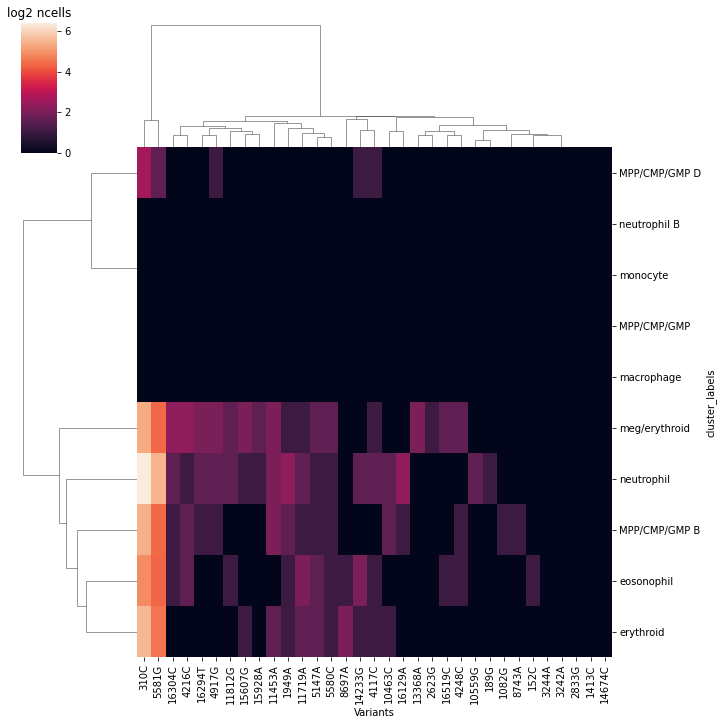

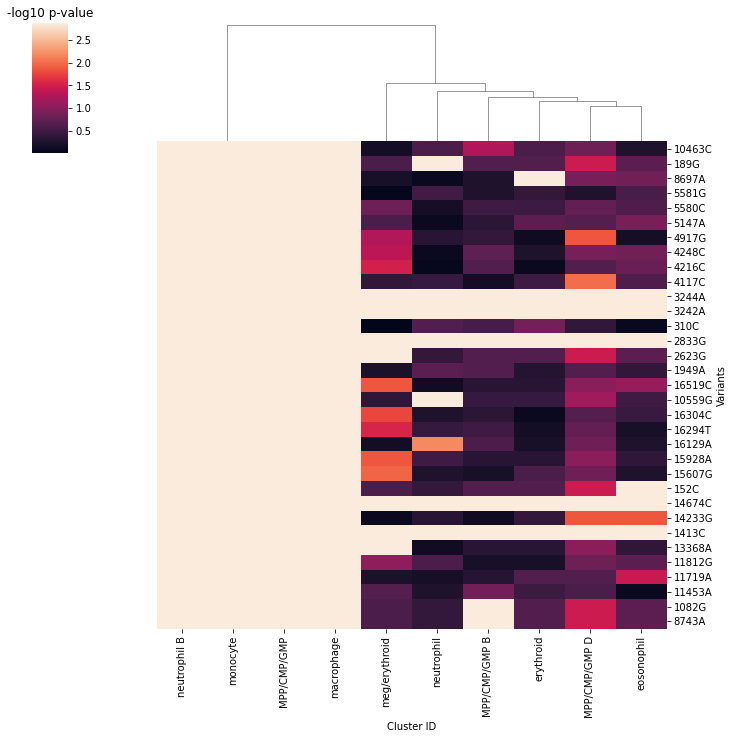

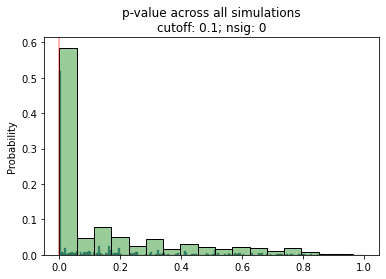

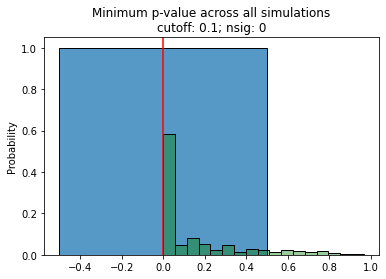

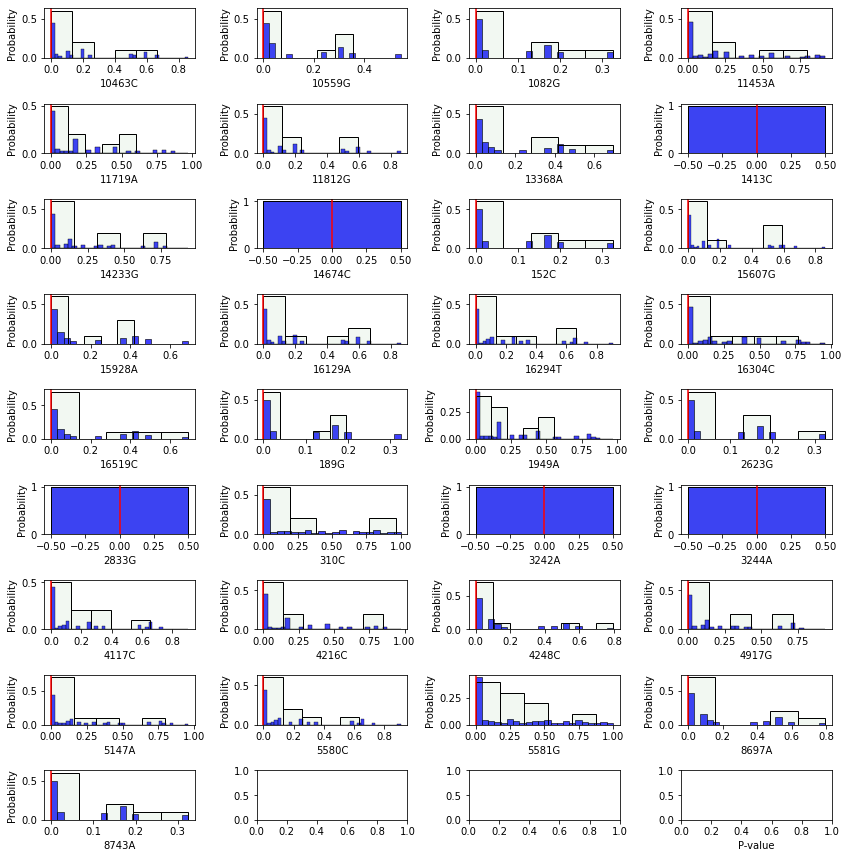

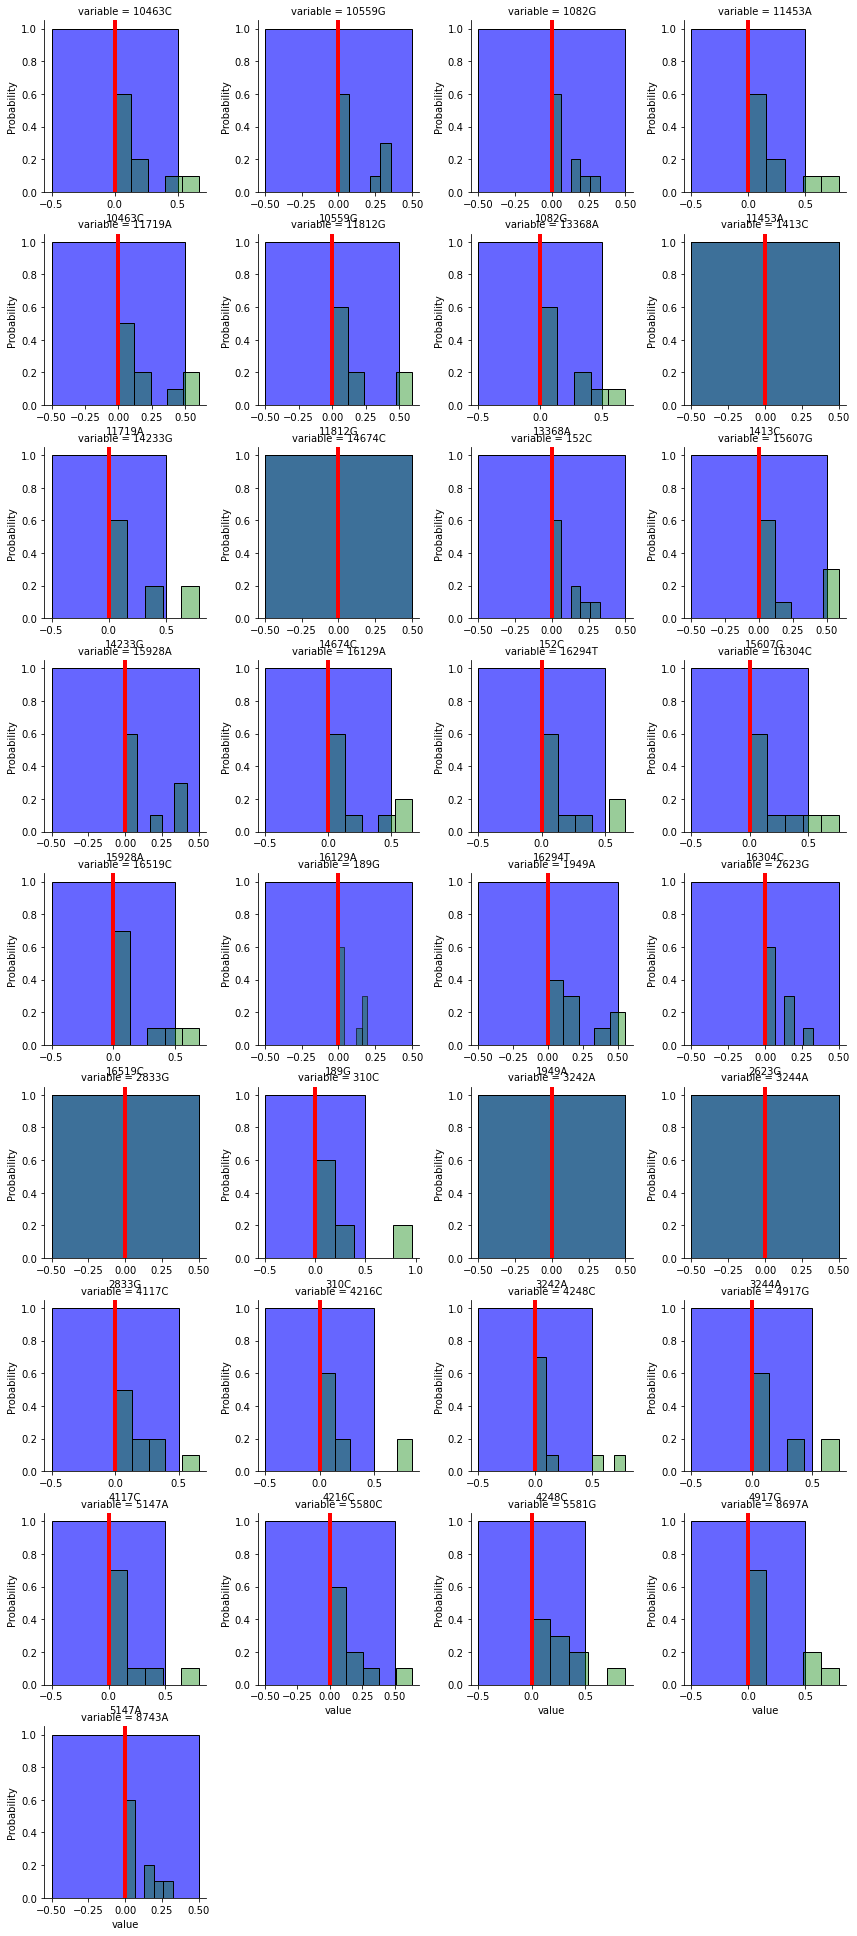

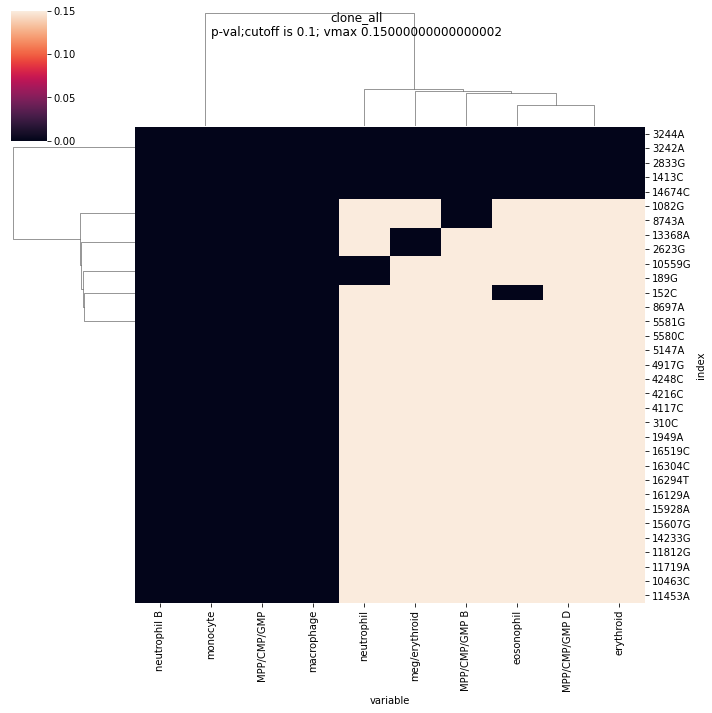

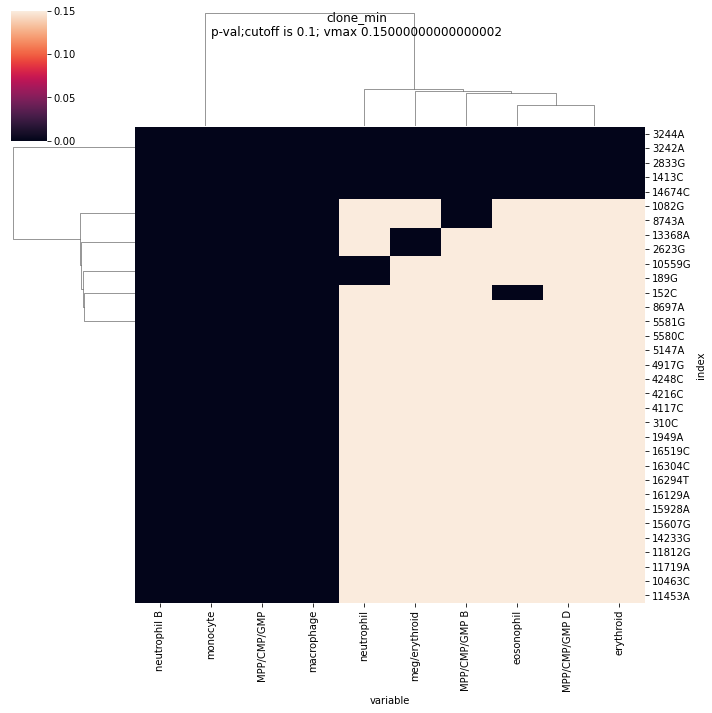

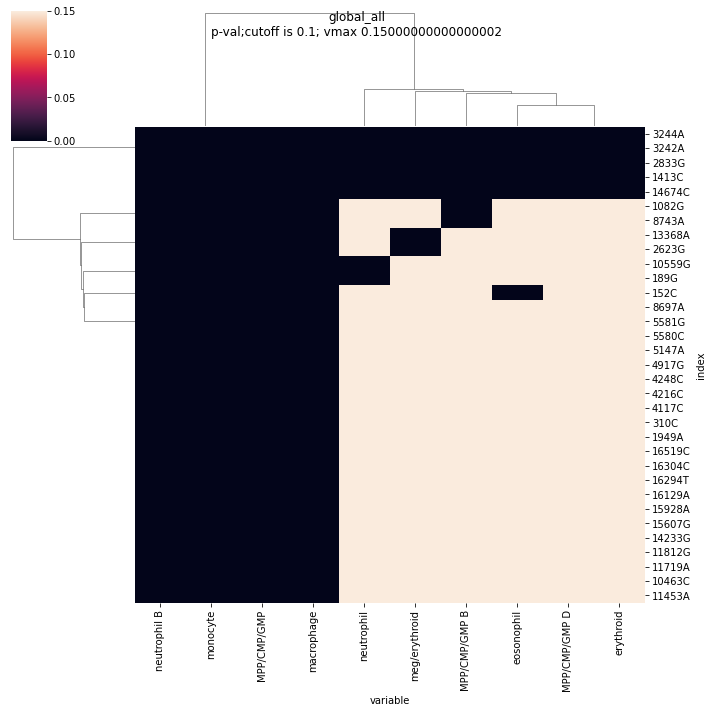

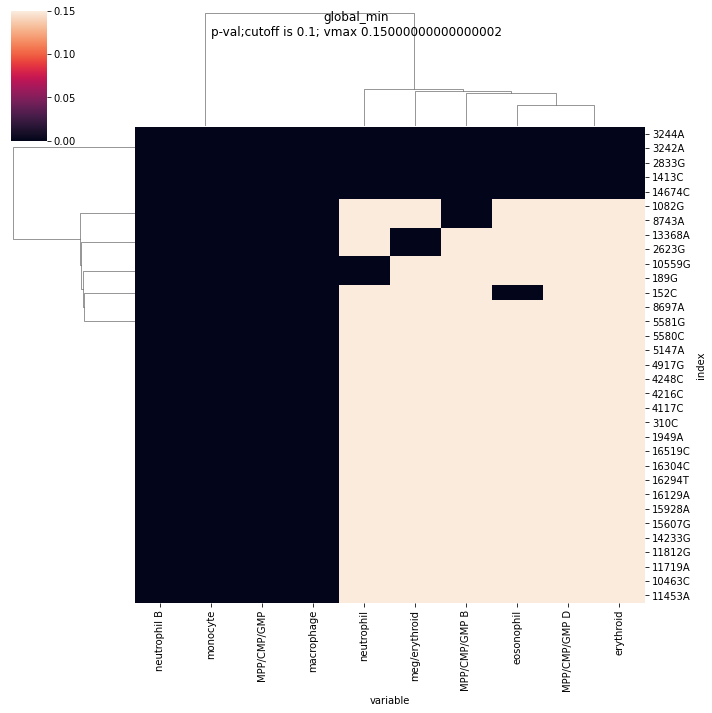

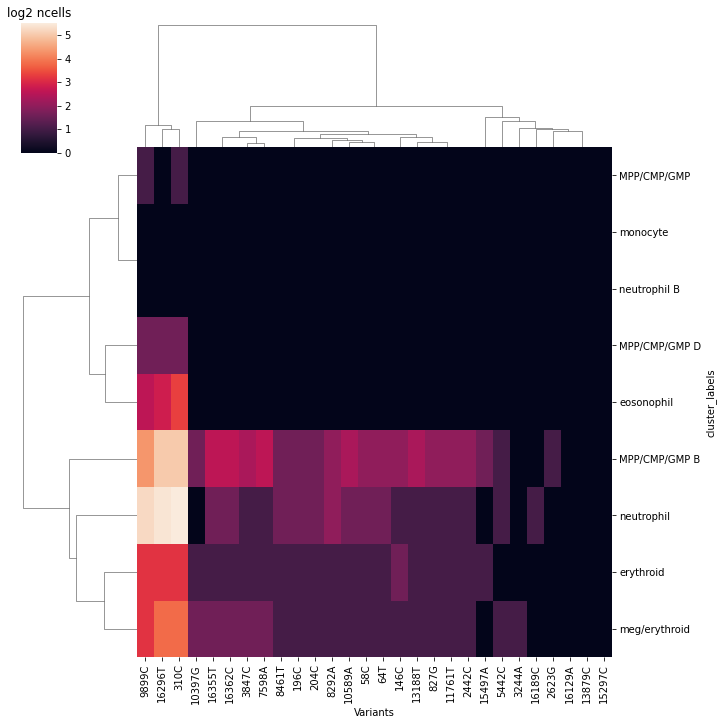

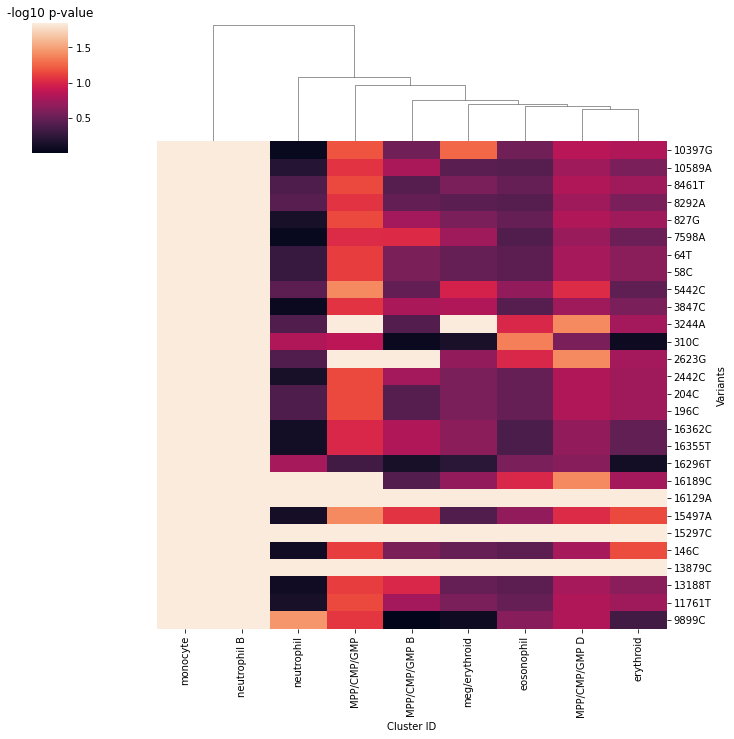

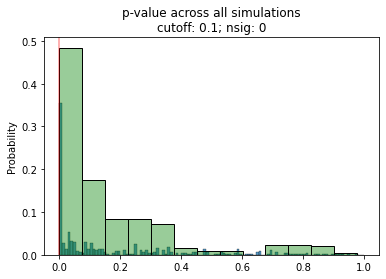

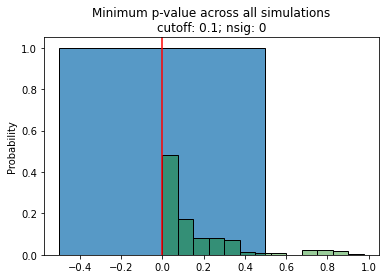

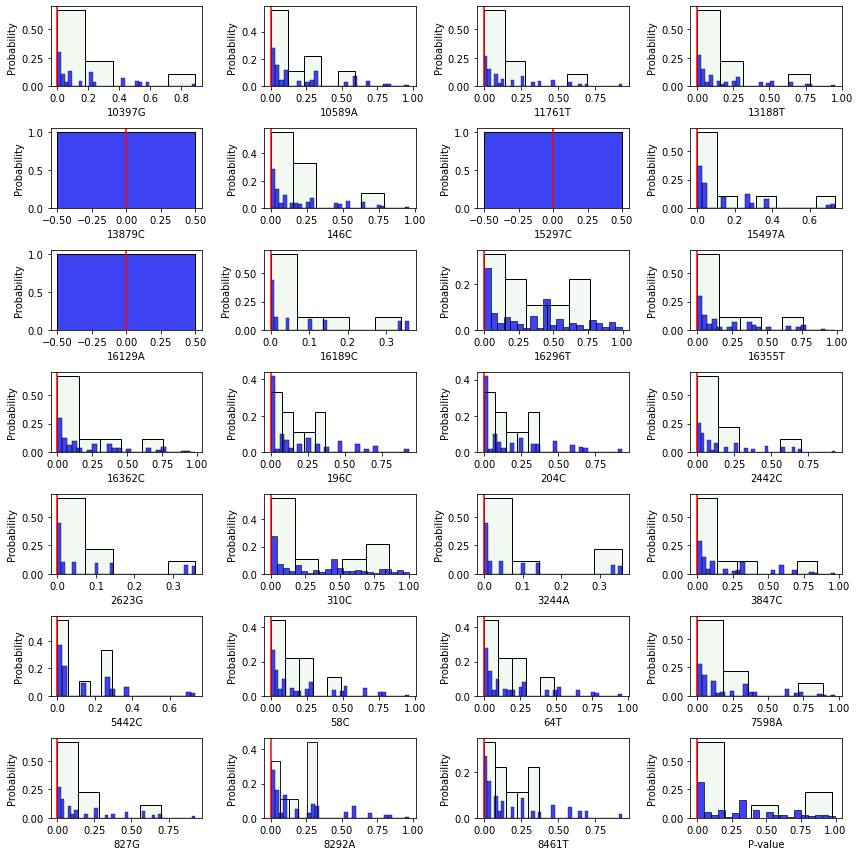

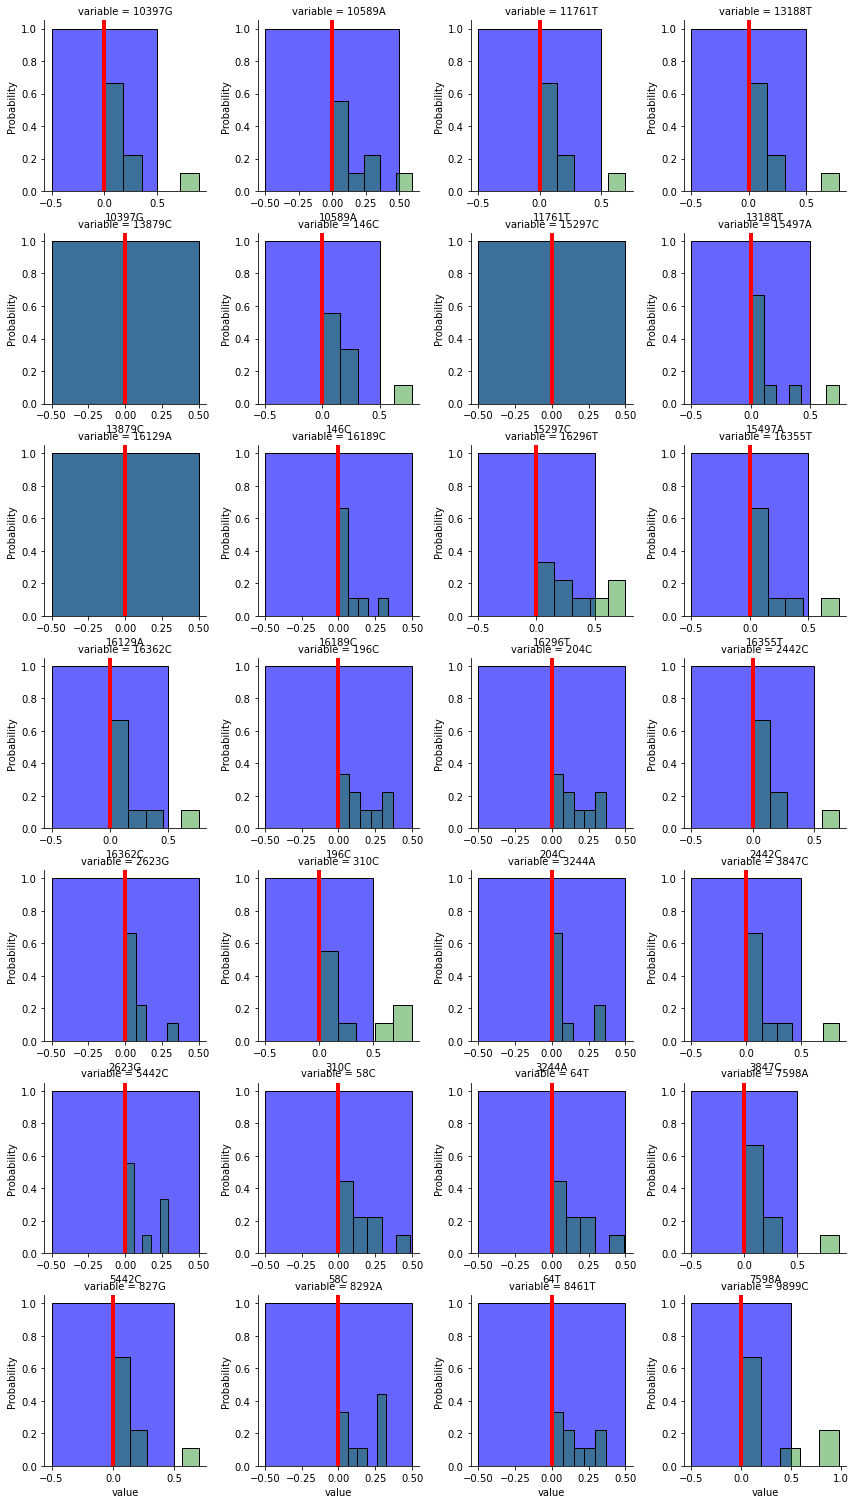

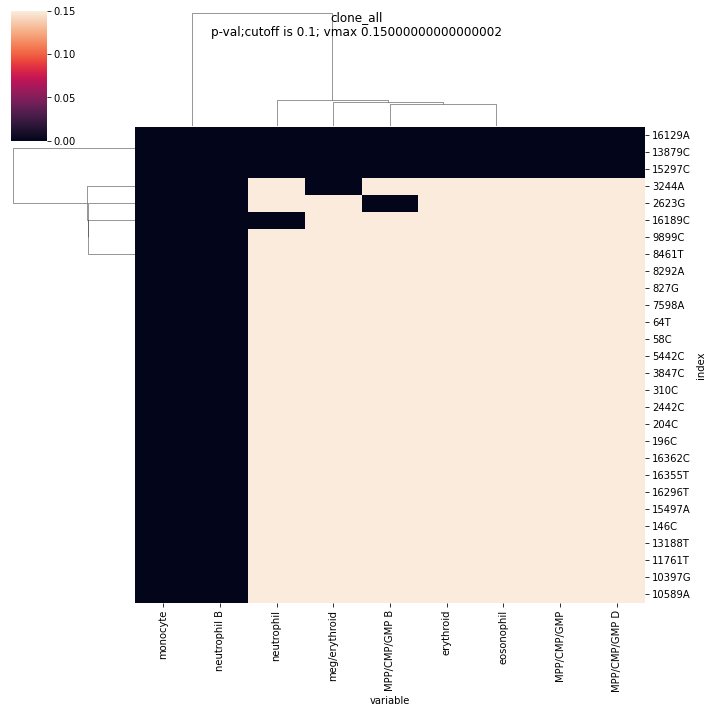

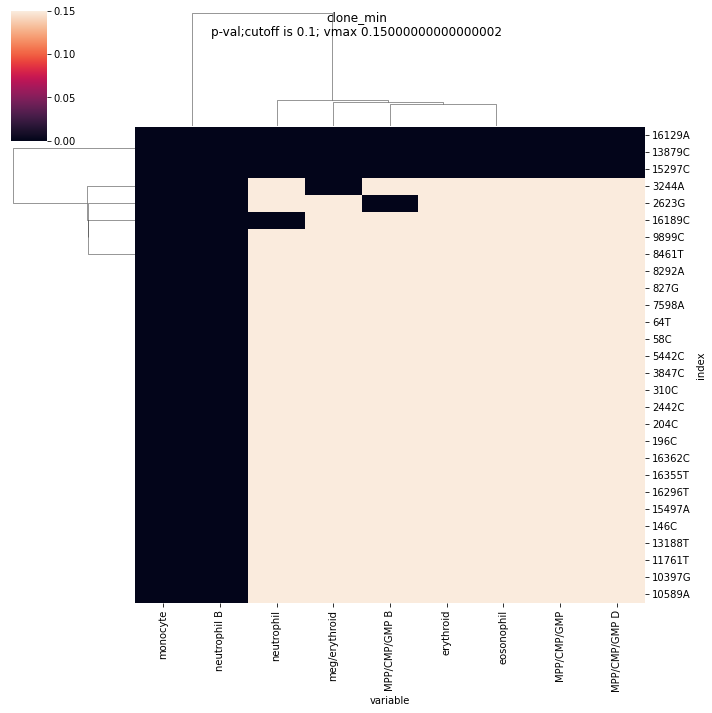

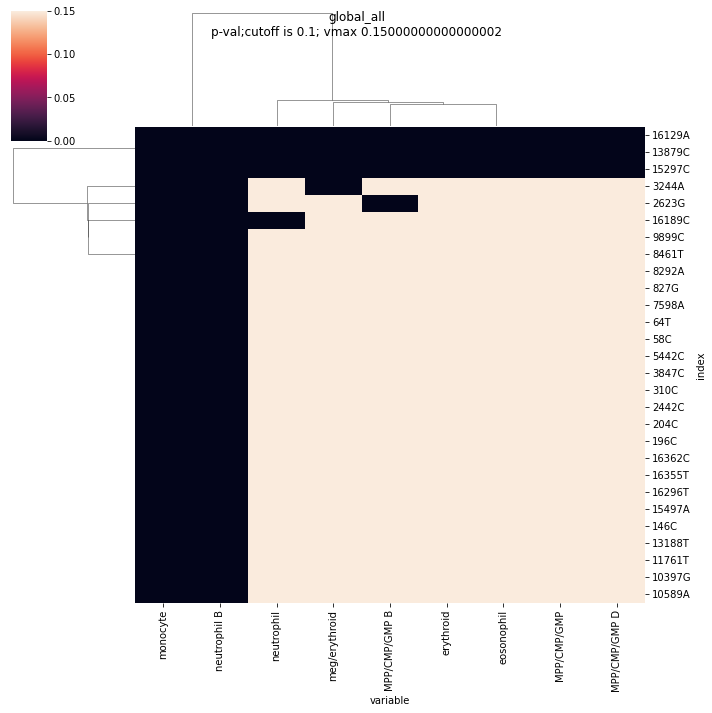

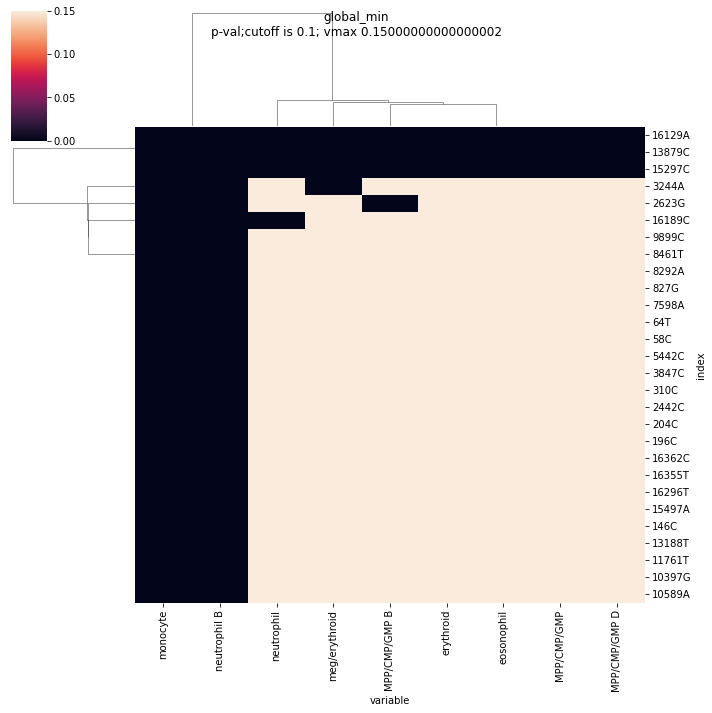

In [10]:
for d, val in lin_mt_ncells.groupby("donor"):
    #curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups = val
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)
    
    #cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes)
    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    
# #     # plot just the counts
# #     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
# #     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# #     plt.gca().set_title("log2 ncells")
# #     plt.savefig(join(curr_don_out, "ncells.png"))
    

ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 7
bh shape (28, 9)


ic| 'clone min'


out_df       clone        lineage  p_value shuffle      method
4    13879C    MPP/CMP/GMP              0.0  global_all
6    15297C    MPP/CMP/GMP              0.0  global_all
8    16129A    MPP/CMP/GMP              0.0  global_all
32   13879C  MPP/CMP/GMP B              0.0  global_all
34   15297C  MPP/CMP/GMP B              0.0  global_all
..      ...            ...              ...         ...
247   7598A   neutrophil B              0.0   clone_min
248    827G   neutrophil B              0.0   clone_min
249   8292A   neutrophil B              0.0   clone_min
250   8461T   neutrophil B              0.0   clone_min
251   9899C   neutrophil B              0.0   clone_min

[320 rows x 4 columns]


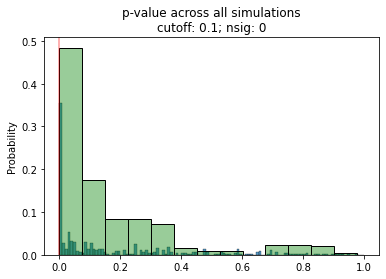

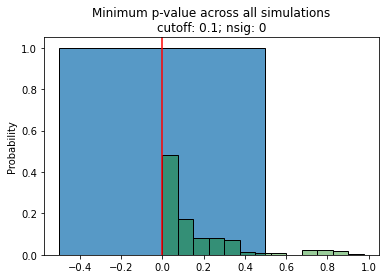

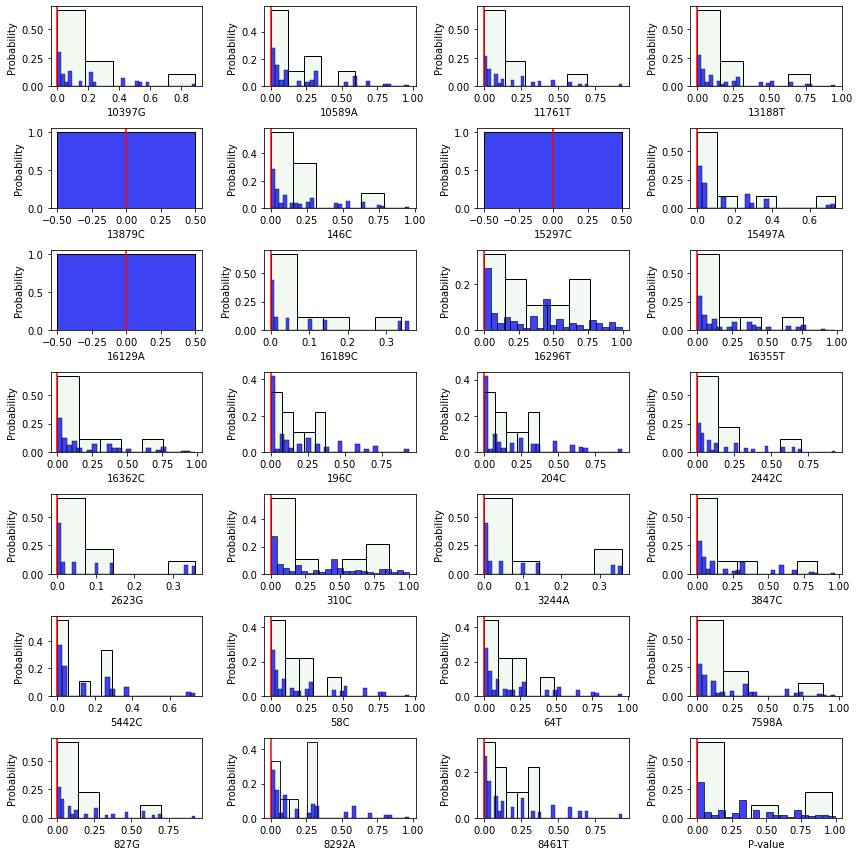

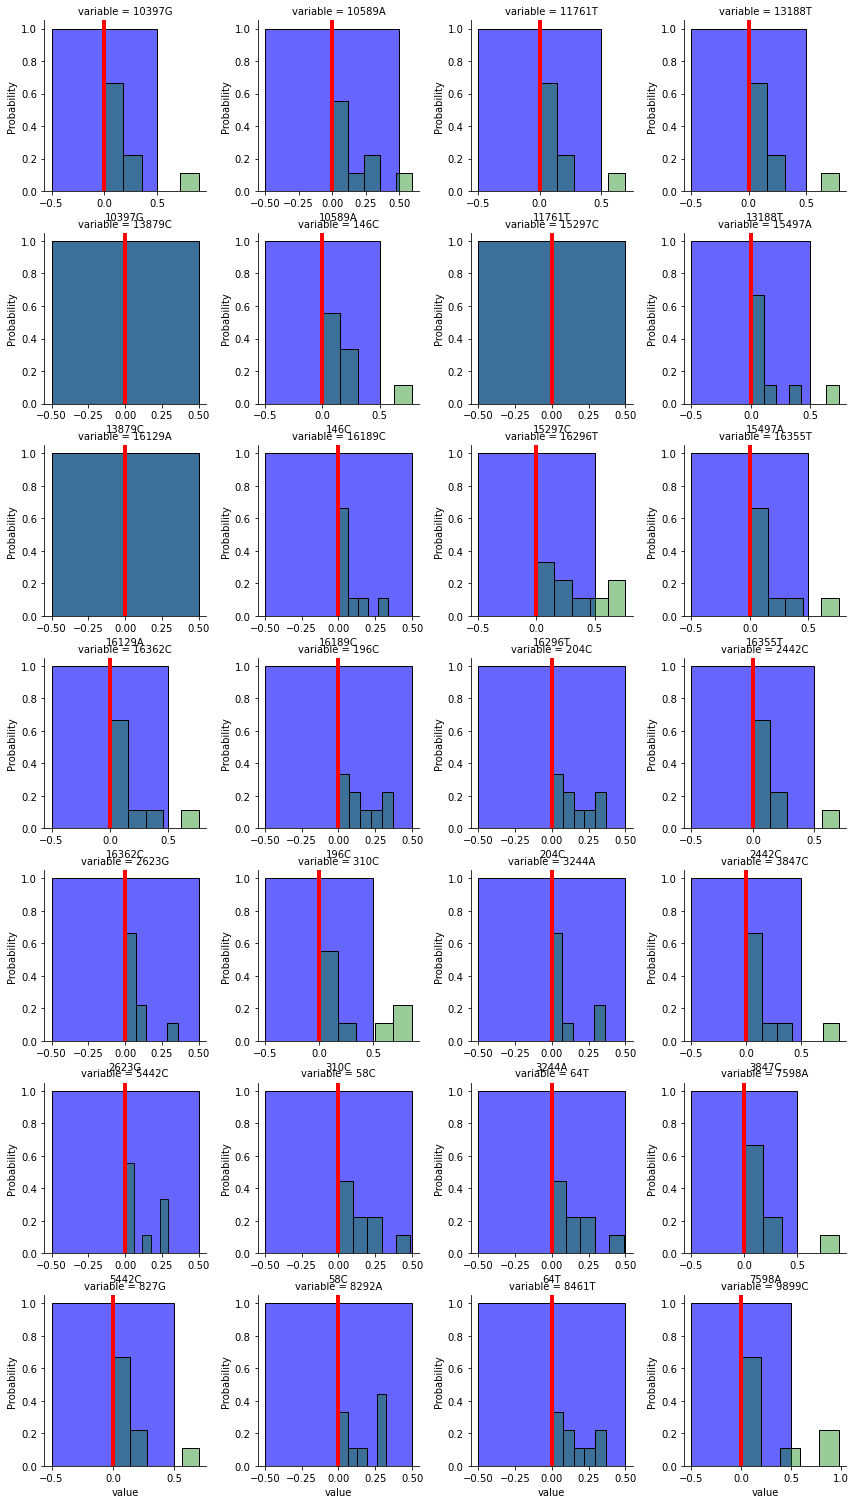

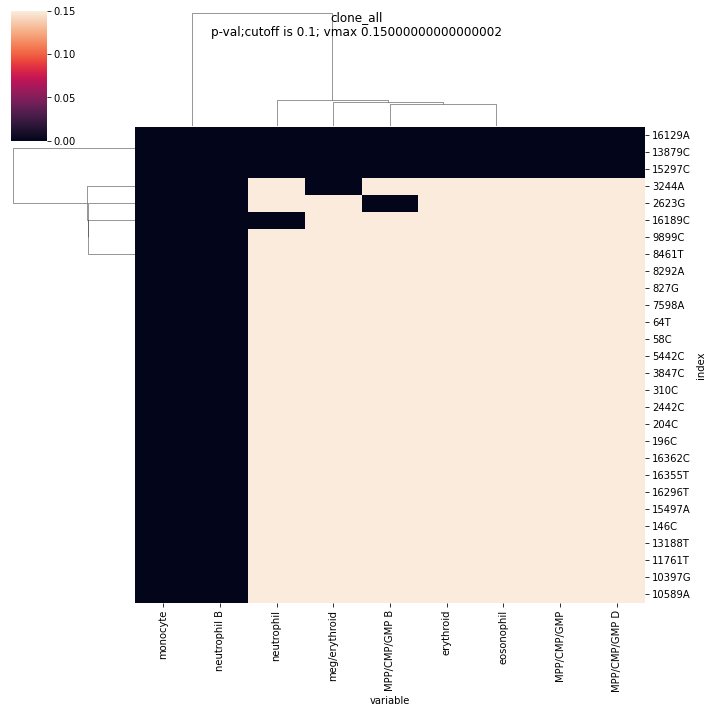

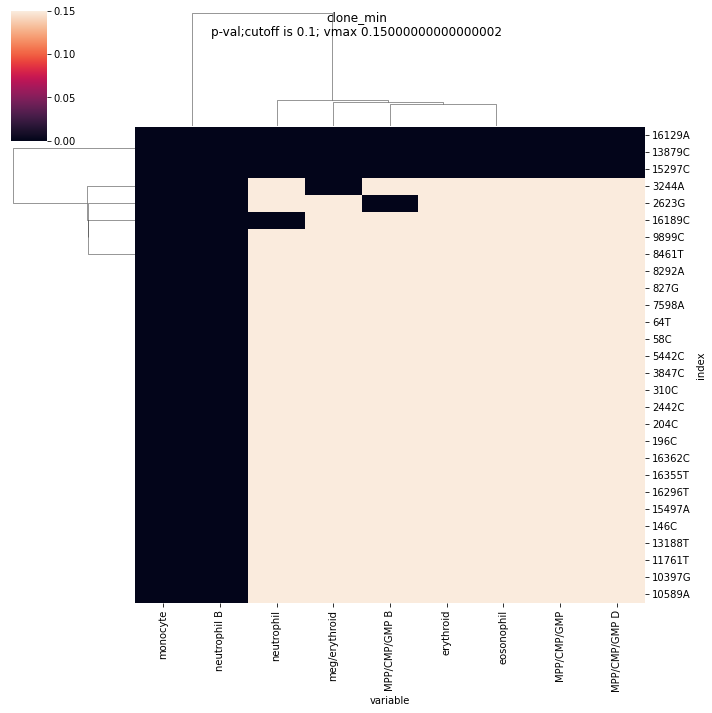

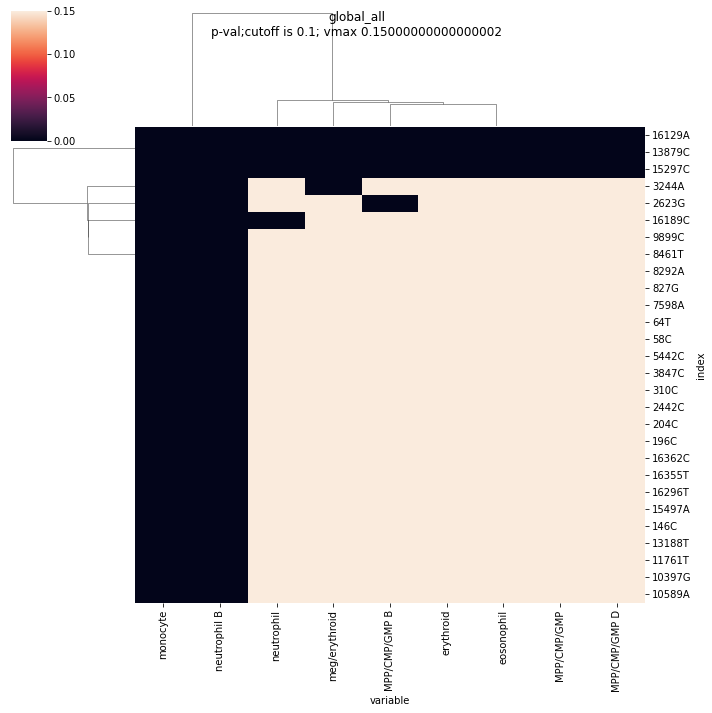

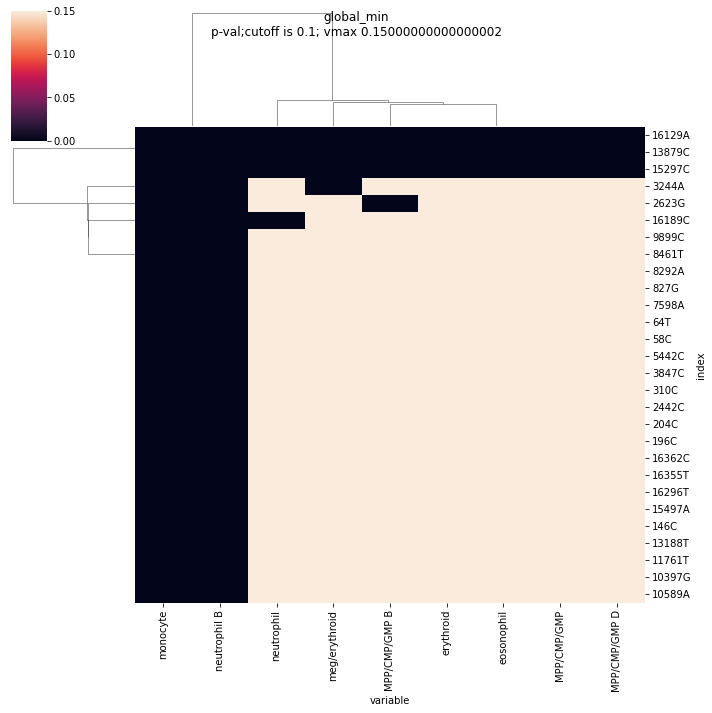

In [11]:
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                  curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)


In [12]:
out_df

,clone,lineage,p_value shuffle,method,BH_p_adj
4,13879C,MPP/CMP/GMP,0.0,clone_all,0.0
6,15297C,MPP/CMP/GMP,0.0,clone_all,0.0
8,16129A,MPP/CMP/GMP,0.0,clone_all,0.0
32,13879C,MPP/CMP/GMP B,0.0,clone_all,0.0
34,15297C,MPP/CMP/GMP B,0.0,clone_all,0.0
...,...,...,...,...,...
247,7598A,neutrophil B,0.0,global_min,0.0
248,827G,neutrophil B,0.0,global_min,0.0
249,8292A,neutrophil B,0.0,global_min,0.0
250,8461T,neutrophil B,0.0,global_min,0.0


In [13]:
#cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh, clones=curr_clones, atac_cl=curr_atac_cl)
#     clones, atac_cl = get_groups(curr_groupsr, curr_clones, curr_atac_cl, clone_col,
#                                  atac_col)

In [14]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)